### document classification example
based on sklearn site example entitled "Classification of text documents using sparse features"
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

 - some of the code appears to be out of date (e.g. old string formatting syntax)
 - much of it is also geared toward CLI runs - adapting it as a notebook
 
 The BSD 3-clause license allows you almost unlimited freedom with the software so long as you include the BSD copyright and license notice in it.

© 2007 - 2021, scikit-learn developers (BSD License). 

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
1.     Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
1.     Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission. 

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [2]:
import indjobs as ij

In [3]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
# modified: Robert Sunderland - 2021

import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import indjobs as i
from types import SimpleNamespace

#changed from CLI options to inline

optdict = {'print_report': True,# Print a detailed classification report.
 'select_chi2': 1500,#Select some number of features using a chi-squared test
 'print_cm': True,#Print the confusion matrix.
 'print_top10': True, #Print ten most discriminative terms per class for every classifier
 'all_categories': True, #Whether to use all categories or not
 'use_hashing': True, #Use a hashing vectorizer
 'n_features': 2**16, #n_features when using the hashing vectorizer
 'filtered': True} #Remove newsgroup information that is easily overfit: headers, signatures, and quoting


optdict

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

In [4]:
#d = {'key1': 'value1', 'key2': 'value2'}
opts = SimpleNamespace(**optdict)
#opts.__dict__
vars(opts)

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

In [6]:
#3rd option
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
opts = objectview(optdict)
#opts.__dict__
vars(opts)

{'print_report': True,
 'select_chi2': 1500,
 'print_cm': True,
 'print_top10': True,
 'all_categories': True,
 'use_hashing': True,
 'n_features': 65536,
 'filtered': True}

# load data

In [7]:
opts.all_categories = False

In [8]:
## load data
if opts.all_categories:
    categories = None
else:
    categories = [
        "alt.atheism",
        "talk.religion.misc",
        "comp.graphics",
        "sci.space",
    ]
print(f"20 newsgroups dataset for categories:{categories if categories else 'all'}")


20 newsgroups dataset for categories:['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [9]:
if opts.filtered:
    remove = ("headers", "footers", "quotes")
else:
    remove = ()
    
remove

('headers', 'footers', 'quotes')

In [10]:
def get_newsgroup_data(uselocalcopy = True, remove = ('headers', 'footers', 'quotes'), categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']):
    import shelve as s
    import os
    shelfloc = r'c:\temp\20newsgroups.dat'
    data_train = None
    data_test = None
    if os.path.exists(shelfloc) and uselocalcopy:
        with s.open(os.path.splitext(shelfloc)[0]) as datastore:
            try: 
                data_train = datastore['data_train']
                data_test = datastore['data_test']
            except KeyError as e:
                print(f'ERROR: could not find key: {e.args[0].decode()}')
                get_newsgroup_data(False)
    else:
        print(f'updating local copy at {shelfloc}')
        from sklearn.datasets import fetch_20newsgroups
        data_train = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)
        data_test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)
        
        #save for later use without doing download
        with s.open(os.path.splitext(shelfloc)[0]) as datastore:
            datastore['data_train'] = data_train
            datastore['data_test'] = data_test
    return data_train, data_test

(data_train, data_test) = get_newsgroup_data(remove=remove, categories=categories)

In [11]:
type(data_train), type(data_test)

(sklearn.utils.Bunch, sklearn.utils.Bunch)

In [12]:
data_train.target

array([1, 3, 2, ..., 1, 0, 1], dtype=int64)

In [13]:
# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [14]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(f"{len(data_train.data)} documents - {data_train_size_mb:0.3}MB (training set)")
print(f"{len(data_test.data)} documents - {data_test_size_mb:0.3}MB (test set)")
print(f"{len(target_names)} categories")

2034 documents - 2.43MB (training set)
1353 documents - 1.8MB (test set)
4 categories


In [15]:
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target
type(y_train), len(y_train), type(y_test), len(y_test)

(numpy.ndarray, 2034, numpy.ndarray, 1353)

In [16]:
opts.use_hashing = False

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words="english", alternate_sign=False, n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print(f"done in {duration:0.5}s at {data_train_size_mb / duration:0.3} MB/s" )
print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}" )

Extracting features from the training data using a sparse vectorizer
done in 0.28932s at 8.39 MB/s
n_samples: 2034, n_features: 26576


In [18]:
f = vectorizer.get_feature_names()#Array mapping from feature integer indices to feature name.
pd.Series(f).sample(10).sort_index()

690        20mbytes
898            2870
2621           acts
4850        bounces
6210          colon
6363     comparison
7744        defunct
20127       regions
21013       rutgers
25960          whew
dtype: object

In [19]:
sorted(vectorizer.vocabulary_)#same as get_feature_names
vectorizer.vocabulary_['reactionary']

19836

In [20]:
print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
#print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
#print("n_samples: %d, n_features: %d" % X_test.shape)
print(f"done in {duration:0.5}s at {data_test_size_mb / duration:0.3} MB/s" )
print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}" )

Extracting features from the test data using the same vectorizer
done in 0.17593s at 10.2 MB/s
n_samples: 1353, n_features: 26576


- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [21]:
# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    #feature_names = vectorizer.get_feature_names_out()#not in v0.23.2
    feature_names = vectorizer.get_feature_names()
pd.Series(feature_names).sample(10).sort_index()

7240        crushing
7527           daveb
9280     enhancement
12009        heretic
13394     invariants
13614            ivr
14144          knife
17506            ose
17758         panama
24627         tychay
dtype: object

In [22]:
from sklearn.feature_selection import SelectKBest, chi2
if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" % opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        #feature_names = feature_names[ch2.get_support()] #fails - filtering a list with a boolean?
        feature_names = pd.Series(feature_names)[ch2.get_support()].values

    print(f"done in {(time() - t0)}s" )

pd.Series(feature_names).sample(10).sort_index()
#def trim(s):
#    """Trim string to fit on terminal (assuming 80-column display)"""
#    return s if len(s) <= 80 else s[:77] + "..."

Extracting 1500 best features by a chi-squared test
done in 0.0235440731048584s


48        accept
274         cobb
421     displays
719          jim
1196      saving
1197     saviour
1241    siggraph
1293     station
1438     viewing
1467        wish
dtype: object

# benchmark classifiers

In [23]:
#benchmark classifiers - utility function
from sklearn import metrics
from sklearn.utils.extmath import density
def benchmark(clf, prettyname=None, apptext = ''):
    """ utiltiy function for determining how good the classifier is 
    doesn't return the output from the classifier"""
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time}fs" )

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time}fs" )

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score}f" )

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}" )
        print(f"density: {density(clf.coef_)}"  )

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(f"{label}: {' '.join(feature_names[top10])}".strip() )
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0] if not prettyname else prettyname
    if len(apptext)>0: 
        clf_descr += f" {apptext}"
    
    return clf_descr, score, train_time, test_time

In [24]:
results = []
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, ))
results

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.03205466270446777fs
test time:  0.0009636878967285156fs
accuracy:   0.7612712490761271f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: cruel deletion islamic atheist islam bobby motto atheists atheism religion
comp.graphics: pov images card 42 hi image file 3d computer graphics
sci.space: air sci moon flight shuttle spacecraft launch nasa orbit space
talk.religion.misc: order abortion koresh rosicrucian christ children jesus fbi christians christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.71      0.58      0.64       319
     comp.graphics       0.88      0.89      0.88       389
         sci.space       0.73      0.92      0.81       394
talk.religion.misc       0.68      0.54      0.60       251

          accuracy            

C:\Users\Rob.DESKTOP-HBG5EOT\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


accuracy:   0.3946784922394678f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.6602611541748047fs
test time:  0.048203229904174805fs
accuracy:   0.7117516629711752f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.58      0.63      0.61  

[('RidgeClassifier',
  0.7612712490761271,
  0.03205466270446777,
  0.0009636878967285156),
 ('Perceptron',
  0.7191426459719142,
  0.010689735412597656,
  0.000997304916381836),
 ('PassiveAggressiveClassifier',
  0.7361419068736141,
  0.019946575164794922,
  0.0010094642639160156),
 ('KNeighborsClassifier',
  0.3946784922394678,
  0.001994609832763672,
  0.10075569152832031),
 ('RandomForestClassifier',
  0.7117516629711752,
  0.6602611541748047,
  0.048203229904174805)]

In [25]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier


for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3), apptext = penalty))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty), apptext=penalty))
    
results

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
train time: 0.016429901123046875fs
test time:  0.0009627342224121094fs
accuracy:   0.7590539541759054f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: nanci islamic islam motto risk atheist bobby atheists religion atheism
comp.graphics: 3do sphere 68070 hi 42 file 3d image computer graphics
sci.space: earth dc moon flight spacecraft nasa launch shuttle orbit space
talk.religion.misc: ekr rosicrucian 666 children cult christ abortion fbi christians christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.58      0.63       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.74      0.91      0.81       394
talk.religion.misc       0.66      0.56      0.60       251

          accuracy                           0.76 

[('RidgeClassifier',
  0.7612712490761271,
  0.03205466270446777,
  0.0009636878967285156),
 ('Perceptron',
  0.7191426459719142,
  0.010689735412597656,
  0.000997304916381836),
 ('PassiveAggressiveClassifier',
  0.7361419068736141,
  0.019946575164794922,
  0.0010094642639160156),
 ('KNeighborsClassifier',
  0.3946784922394678,
  0.001994609832763672,
  0.10075569152832031),
 ('RandomForestClassifier',
  0.7117516629711752,
  0.6602611541748047,
  0.048203229904174805),
 ('LinearSVC l2',
  0.7590539541759054,
  0.016429901123046875,
  0.0009627342224121094),
 ('SGDClassifier l2', 0.7583148558758315, 0.012965202331542969, 0.0),
 ('LinearSVC l1', 0.7450110864745011, 0.026942014694213867, 0.0),
 ('SGDClassifier l1',
  0.7605321507760532,
  0.03293943405151367,
  0.0009694099426269531)]

In [26]:
# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"), apptext='EN')
)

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.03393697738647461fs
test time:  0.0fs
accuracy:   0.762010347376201f
dimensionality: 1500
density: 0.7538333333333334
top 10 keywords per class:
alt.atheism: atheists punish nanci religion motto texts atheist bobby risk atheism
comp.graphics: pov file sphere 3do image 68070 3d 42 computer graphics
sci.space: star rocket nasm centaur nasa liftoff launch shuttle orbit space
talk.religion.misc: christian authority abortion 666 terrorist fbi cult josephus ekr christians

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.58      0.63       319
     comp.graphics       0.90      0.88      0.89       389
         sci.space       0.75      0.90      0.82       394
talk.religion.misc       0.64      0.59      0.61       251

          accuracy          

In [27]:
# Train NearestCentroid without threshold
from sklearn.neighbors import NearestCentroid
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.003989696502685547fs
test time:  0.0fs
accuracy:   0.7354028085735402f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.64      0.53      0.58       319
     comp.graphics       0.90      0.83      0.86       389
         sci.space       0.72      0.90      0.80       394
talk.religion.misc       0.62      0.60      0.61       251

          accuracy                           0.74      1353
         macro avg       0.72      0.71      0.71      1353
      weighted avg       0.74      0.74      0.73      1353

confusion matrix:
[[168  11  58  82]
 [ 15 322  47   5]
 [ 18  18 354   4]
 [ 63   5  32 151]]



In [28]:
# Train sparse Naive Bayes classifiers
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
train time: 0.001987934112548828fs
test time:  0.000978708267211914fs
accuracy:   0.7730968218773097f
dimensionality: 1500
density: 1.0
top 10 keywords per class:
alt.atheism: believe atheists said atheism religion say think people don god
comp.graphics: help need hi looking program image file files thanks graphics
sci.space: people shuttle don earth think moon launch orbit nasa space
talk.religion.misc: say did bible think christians don christian people jesus god

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.66      0.67       319
     comp.graphics       0.91      0.89      0.90       389
         sci.space       0.77      0.91      0.83       394
talk.religion.misc       0.66      0.52      0.58       251

          accuracy                           0.77      1353
         macro

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline([("feature_selection",SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),),
                ("classification", LinearSVC(penalty="l2")),]
        ), apptext='svc w L1 sel'
    )
)

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.038924455642700195fs
test time:  0.00096893310546875fs
accuracy:   0.7516629711751663f
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.56      0.62       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.73      0.90      0.81       394
talk.religion.misc       0.65      0.56      0.60       251

          accuracy                           0.75      1353
         macro avg       0.74      0.73      0.73      1353
      weighted avg       0.75      0.75      0.75      1353

confusion matrix:
[[180  

# add plots

In [30]:
#results table --  
rdf = pd.DataFrame(results)
rdf

,0,1,2,3
0,RidgeClassifier,0.761271,0.032055,0.000964
1,Perceptron,0.719143,0.010690,0.000997
2,PassiveAggressiveClassifier,0.736142,0.019947,0.001009
3,KNeighborsClassifier,0.394678,0.001995,0.100756
4,RandomForestClassifier,0.711752,0.660261,0.048203
5,LinearSVC l2,0.759054,0.016430,0.000963
6,SGDClassifier l2,0.758315,0.012965,0.000000
7,LinearSVC l1,0.745011,0.026942,0.000000
8,SGDClassifier l1,0.760532,0.032939,0.000969
9,SGDClassifier EN,0.762010,0.033937,0.000000


In [31]:
rdf.columns = [x.strip() for x in 'clf_descr, score, train_time, test_time'.split(',')]
rdf.set_index('clf_descr').sort_values('score',ascending = False)

,score,train_time,test_time
clf_descr,,,
MultinomialNB,0.773097,0.001988,0.000979
ComplementNB,0.770140,0.001994,0.000970
SGDClassifier EN,0.762010,0.033937,0.000000
RidgeClassifier,0.761271,0.032055,0.000964
SGDClassifier l1,0.760532,0.032939,0.000969
LinearSVC l2,0.759054,0.016430,0.000963
SGDClassifier l2,0.758315,0.012965,0.000000
Pipeline svc w L1 sel,0.751663,0.038924,0.000969
BernoulliNB,0.747967,0.001996,0.001024


In [32]:
#add plots
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

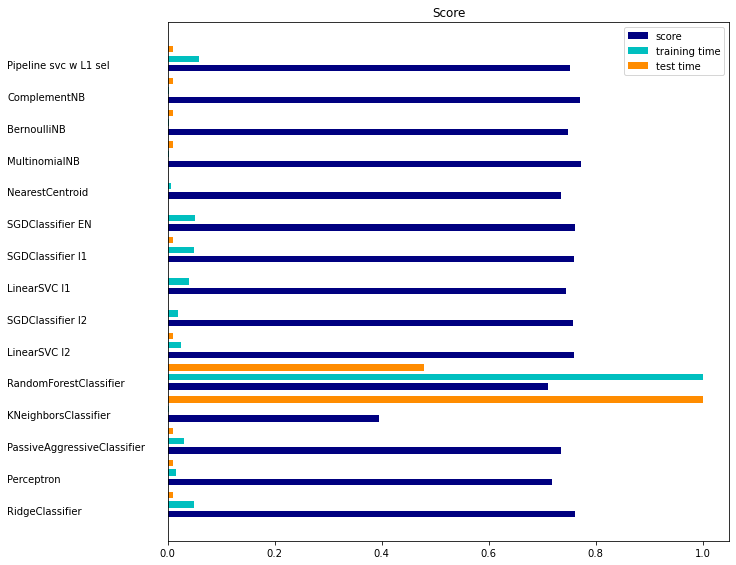

In [33]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

## one-off Kneighbors

In [34]:
y_train

array([1, 3, 2, ..., 1, 0, 1], dtype=int64)

In [35]:
pd.DataFrame(X_train.todense()).describe()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,...,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,0.001471,0.002999,0.000376,0.002156,0.000599,0.002771,0.000514,0.000599,0.001565,0.003045,...,0.000226,0.000275,0.001091,0.000942,0.000302,0.003947,0.005437,0.000844,0.000273,0.000964
std,0.014319,0.015627,0.008293,0.014780,0.010190,0.017775,0.011125,0.010190,0.015390,0.021971,...,0.010199,0.008000,0.016695,0.021118,0.012899,0.020612,0.021339,0.021277,0.005909,0.014158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.280698,0.201979,0.259718,0.184582,0.214754,0.304715,0.342437,0.214754,0.354277,0.364062,...,0.459983,0.317610,0.475821,0.620357,0.580812,0.348775,0.224543,0.582961,0.164637,0.362648


In [36]:
# does this sklearn version have plot_decision_boundaries()?

In [37]:
#skeleton for one-off run
clf = KNeighborsClassifier(n_neighbors=10)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)

score = metrics.accuracy_score(y_test, pred)


if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]


In [38]:
pred2 = clf.predict(X_train)
pred2 == y_train

array([False, False,  True, ..., False,  True, False])

In [39]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 10,
 'p': 2,
 'weights': 'uniform'}

In [40]:
pd.Series(y_train).value_counts()

2    593
1    584
0    480
3    377
dtype: int64

In [41]:
pred_s = pd.Series(pred)
pred_s.value_counts()

0    421
1    379
2    377
3    176
dtype: int64

# Clustering
<div style="color:red;">copied this to the README file, too</div>
Clustering cannot use the same accuracy measures as classification because the numberic label assignments are arbitrary (e.g. the label predicted label of 0 is the first group determined and un related to the y_train label encoded as 0).  

- https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
- https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Evaluating clustering
- **Inertia** - how internall coherent clusters are
    - works best with ball shaped clusters
    - how close all cluster members are to the centroid for their cluster
    - some of squared distances from all points to nearest centroid
    - lower numbers are better
    - kmeans.inertia_ (kmeans attempts to minimize)
        - can be used to determine the optimal number of clustesrs (if ball shaped)
- **purity**
    1. assign a label to the class based on the class that is most frequent in that cluster
    2. count the number of correctly assigned documents and divide by the total number of items
    1. not implemented directly in sklearn (probaly b/c usefulness is limited)
    1. using contingency matrix (aka confusion matrix) - where TP is based on the most common of the actual label assignments for that cluster
        - $ \frac{TP}{N} $ where $ N= TP+TN+FP+FN$
        - sklearn.metrics.cluster.contingency_matrix(y_act, y_pred)
- **NMI (normalized mutual information)** - compensates for high purity obtaine when n_clusters is large - assumes max likelihood estimatse.  Given cluster as predicted cluster membership and...  class as actual labels based on human judgement
    - information gain from knowing the class - if the clustering is random compared to classes then no information is gained (0 to 1)
    - normalizing by entropy penalizes large settings of n_clusters, b/c it increases with n_clusters making overall result smaller
    - log of 
        - probability an item being in both cluster and class (intersection)
        - div by the product of the probability of it being in the class and the probability of it being in the cluster
    - divided by entropy
    - `sklearn.metrics.normalized_mutual_info_score(labels_true, labels_pred)` *- OR -* `adjusted_mutual_info_score` *- OR -*  `mutual_info_score`
        - e.g. how often do predicted assignments match with actual
        - adjusted is adjusted for chance, others are not
        - ignores group(label) names
        - values tend toward 0
- **Rand index** - penalizes both false positive and false negative  viewing the clustering as a series of decisions what is the percentage of these decisions that was correct
    - accuracy formula
    - `sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)`
        - renaming labels doesn't change the score
        - values tend toward 1 even for very bad mappings
    - similarity of the pair cluster assignments, ignoring permutations
    - create confusion matrix of 
        - TP - two documents are similar and in same cluster (correct)
        - TN - two dissimilar documents documents in different clusters (correct)
        - FP - two dissimilar documents documents in same cluster (error)
        - FN - two similar documents assigned to diff clusters

$ \mbox{RI} = \frac{\mbox{TP}+\mbox{TN}}{\mbox{TP}+\mbox{FP}+\mbox{FN}+\mbox{TN}} $

- **F measure** - penalty for FP and NP and also allows for weights on these
    - Separating similar documents is sometimes worse than putting pairs of dissimilar documents in the same cluster.
    - use a weight $ \beta $ gives more weight to recall (over precision) by penalizing false negatives more than false 
positives -- e.g. it is better to say that two things are related (in the same cluster) and they aren't then to say they aren't related (in diff clusters) and they are

$ \begin{pmatrix}6\\2 \end{pmatrix} = C(6,2) = $ combination of 6 items taken 2 at a time - there is no corresponding way to represent permutations

In [42]:
#testing a function that was moved to module
pts = [(0,10),(5,5),(4,3),(1,1),(3,4), (8, 5), (0, 1), (5, 1), (5, 9), (0, 8), (1, 5), (1, 8), (1, 3), (2, 6), (6, 2), [1, 2], [8, 2], [4, 0], [6, 2], [4, 9], [8, 6], [9, 2], [3, 2], [7, 5], [6, 5]]
ctrs = [(0,0), (0,10), (7,7)]

ij.inersha(pts, ctrs)

for point (0, 10)---(0, 10) is closest with dist 0.00
for point (5, 5)---(7, 7) is closest with dist 2.83
for point (4, 3)---(0, 0) is closest with dist 5.00
for point (1, 1)---(0, 0) is closest with dist 1.41
for point (3, 4)---(0, 0) is closest with dist 5.00
for point (8, 5)---(7, 7) is closest with dist 2.24
for point (0, 1)---(0, 0) is closest with dist 1.00
for point (5, 1)---(0, 0) is closest with dist 5.10
for point (5, 9)---(7, 7) is closest with dist 2.83
for point (0, 8)---(0, 10) is closest with dist 2.00
for point (1, 5)---(0, 0) is closest with dist 5.10
for point (1, 8)---(0, 10) is closest with dist 2.24
for point (1, 3)---(0, 0) is closest with dist 3.16
for point (2, 6)---(0, 10) is closest with dist 4.47
for point (6, 2)---(7, 7) is closest with dist 5.10
for point [1, 2]---(0, 0) is closest with dist 2.24
for point [8, 2]---(7, 7) is closest with dist 5.10
for point [4, 0]---(0, 0) is closest with dist 4.00
for point [6, 2]---(7, 7) is closest with dist 5.10
for poi

330.0

In [43]:
x= np.random.randint(0,10, 20).reshape(10,2)
[x for x in dir(x) if x[0] != '_']
repr(x.tolist())

'[[3, 9], [7, 6], [7, 6], [3, 9], [2, 9], [4, 1], [7, 9], [1, 9], [6, 3], [8, 7]]'

In [44]:
from itertools import permutations, combinations
import random
random.seed(42)
repr(random.sample(list(permutations(range(10),2)),k=10))# choices would sample with replacement)

'[(9, 0), (1, 6), (0, 4), (3, 9), (3, 5), (3, 1), (1, 9), (1, 5), (9, 5), (7, 6)]'

In [45]:
list(combinations(range(3,6), 2))


[(3, 4), (3, 5), (4, 5)]

## one-off unsupervised KNN
 https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors
 
 - no predict step? irrelevant because the classes are arbitrary

In [46]:
from sklearn.neighbors import NearestNeighbors
clf = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')

nbrs = clf.fit(X_train)

C:\Users\Rob.DESKTOP-HBG5EOT\.conda\envs\myenv\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [48]:
[x for x in dir(nbrs) if x[0] != '_']

['algorithm',
 'effective_metric_',
 'effective_metric_params_',
 'fit',
 'get_params',
 'kneighbors',
 'kneighbors_graph',
 'leaf_size',
 'metric',
 'metric_params',
 'n_features_in_',
 'n_jobs',
 'n_neighbors',
 'n_samples_fit_',
 'p',
 'radius',
 'radius_neighbors',
 'radius_neighbors_graph',
 'set_params']

In [49]:
# the graph is a compressed sparsed row matrix of relationships with shape (datarows X datarows)
# a row is placed in the (i,j) location if the 2 rows are neighbors'
# e.g. the first index will have 1s in all the columns for input rows that are neighbors
nbrs.kneighbors_graph().toarray()
#[x for x in dir(x) if x[0] != '_']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
clf.kneighbors_graph?

# one-off spectral clustering

In [103]:
X_train.mean(), X_train.max(), X_train.min()

(0.001256166211988377, 1.0, 0.0)

In [23]:
from sklearn.cluster import SpectralClustering

In [108]:
#skeleton for one-off run
clf = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0, affinity='rbf')#.fit(X)

sptrl = clf.fit(X_train) #clf.fit_predict(X_train) gives the labels directly

In [109]:
sptrl.labels_, pd.DataFrame(sptrl.affinity_matrix_),sptrl.n_features_in_

(array([1, 0, 3, ..., 1, 0, 3], dtype=int64),
           0         1         2         3         4         5         6     \
 0     1.000000  0.560041  0.513476  0.496981  0.553983  0.453599  0.555061   
 1     0.560041  1.000000  0.576836  0.558306  0.622342  0.509571  0.617598   
 2     0.513476  0.576836  1.000000  0.511884  0.570596  0.467202  0.566247   
 3     0.496981  0.558306  0.511884  1.000000  0.552266  0.461604  0.555312   
 4     0.553983  0.622342  0.570596  0.552266  1.000000  0.504059  0.633117   
 ...        ...       ...       ...       ...       ...       ...       ...   
 2029  0.386377  0.434054  0.397964  0.385180  0.429359  0.351557  0.426086   
 2030  0.560233  0.629363  0.577034  0.558497  0.622555  0.509746  0.681071   
 2031  0.516833  0.580608  0.532332  0.537434  0.574327  0.470257  0.569950   
 2032  0.467691  0.525402  0.489632  0.469616  0.519718  0.438436  0.520005   
 2033  0.706064  0.793188  0.727237  0.703875  0.784608  0.642434  0.778628   
 
    

`import mlxtend as mlx`
- PACKAGE CONTENTS
    - _base (package)
    - classifier (package)
    - cluster (package)
    - data (package)
    - evaluate (package)
    - externals (package)
    - feature_extraction (package)
    - feature_selection (package)
    - file_io (package)
    - frequent_patterns (package)
    - image (package)
    - math (package)
    - plotting (package)
    - preprocessing (package)
    - regressor (package)
    - text (package)
    - utils (package)

In [117]:
plt.subplot?


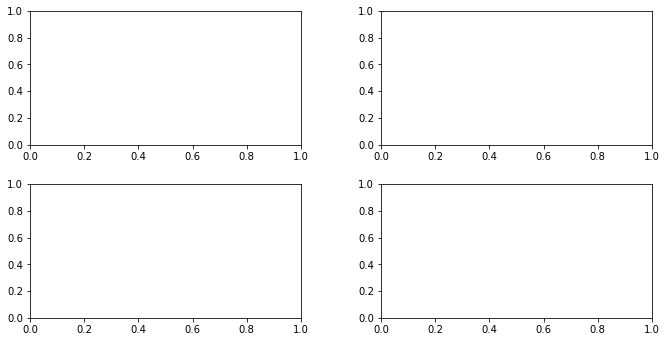

In [135]:
fig.get_size_inches()
#fig.set_size_inches(10,5)
fig

<ipython-input-124-5b190de6cf49>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


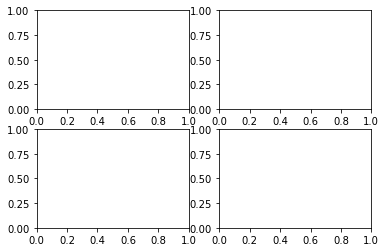

In [124]:
ax = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
fig = ax.get_figure()


In [141]:
del do_sil_plot

In [140]:
import indjobs as i
i.do_sil_plot()

AttributeError: module 'indjobs' has no attribute 'do_sil_plot'

In [143]:
from sklearn.metrics import silhouette_samples
sil_vals_train = silhouette_samples(X_train, sptrl.labels_, metric='euclidean')

i.do_sil_plot(sil_vals_train, sptrl.labels_ )

AttributeError: module 'indjobs' has no attribute 'do_sil_plot'

0 0
1 1
2 2


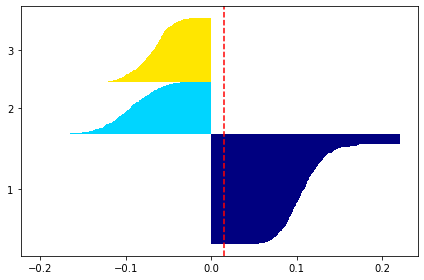

In [98]:
silhouette_vals = silhouette_samples(X_test, pred, metric = 'euclidean')
do_sil_plot(silhouette_vals, pred)

In [ ]:
if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

## one-off Kmeans clustering
clustering = un-labeled data = unsupervised

In [94]:
from sklearn.cluster import KMeans

In [95]:
clf = KMeans(n_clusters=4)

In [96]:
#skeleton for one-off run
clf.fit(X_train, y_train)

KMeans(n_clusters=4)

0 0
1 1
2 2
3 3


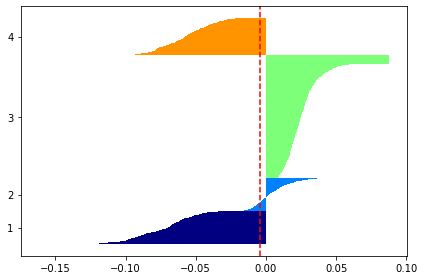

In [100]:
km_train_sil_vals = silhouette_samples(X_train, clf.labels_, metric='euclidean')
do_sil_plot(km_train_sil_vals, clf.labels_)

In [97]:
clf.cluster_centers_

array([[0.00232604, 0.00221011, 0.00255175, ..., 0.        , 0.        ,
        0.00497942],
       [0.00336517, 0.00718788, 0.        , ..., 0.00020862, 0.        ,
        0.        ],
       [0.00118743, 0.00235065, 0.        , ..., 0.0015007 , 0.        ,
        0.00039028],
       [0.        , 0.00219982, 0.        , ..., 0.        , 0.00164185,
        0.00010587]])

In [48]:
lab_s = pd.Series(clf.labels_)
lab_s.value_counts(0)

2    1239
0     401
3     388
1       6
dtype: int64

In [49]:
clf.labels_

array([3, 2, 2, ..., 3, 0, 2])

In [50]:
pd.DataFrame([('TP', 'FN'),('FP', 'TN')], columns = ['pred_pos', 'pred_neg'], index=['act_pos', 'act_neg'])

,pred_pos,pred_neg
act_pos,TP,FN
act_neg,FP,TN


## interpreting multi-class confusion matrix
[helps a bit but wording is confusing](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/)

|population = P+N|pred_pos|pred_neg|
| --- | --- | --- |
|act_pos|TP|FN|
|act_neg|FP|TN|

- TP = 
    - prediction was correct - the diagonal of CF
    - CF\[0,0\]
- FN = 
    - predicted something other than actual 
    - for row 0 the sum of all values in columns\[1:\] for this row
    - The sum of valuesiun the row except the TP value

- FP = 
    - predicted value was incorrect
    - for column 0 the sum of all values in rows\[1:\] 
    - The sum of values of corresponding column except the TP value.

- TN = 
    - we poredicted it wasn't this, and it isn't - 
    - The sum of everything that isn't in the row or column for the class

performance:
- Accuracy (ACC) = (TP + TN)/(P + N) = (true_pos+true_neg) / (act_pos+act_neg)
- precision= TP/PP = true_postive / sum(pred_pos)
- recall/sensitivity = TP/P  = true_positive / sum(act_pos)

### notes from a bad site with lots of tricksy pop-up ads
- accuracy
    - range 0 to 1
    - calc = (TP+TN) divided by 'total number of a dataset P+N' (what does that mean? everything)
    - balanced accruacy average of proprotion of corrects of each class individually 
    
### notes from a less bad site
https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd
same author as the link above?
- accuracy = $ \large \frac{(TN+TP)}{(TN+TP+FP+FN)} $
- precision = $ \large \frac{TP}{(TP+FP)} $
- recall = $ \large\frac{TP}{(TP+FN)} $
-  F1 $ = 2 \times \large \frac{(precision \times recall)}{(precision + recall)} $ - is this being used in place of the accuracy score because accuracy == bad

### notes from BMC site
https://www.bmc.com/blogs/confusion-precision-recall/
- Precision = TP/(TP + FP)
- Recall = TP/(TP + FN)

In [51]:
CF = pd.DataFrame(metrics.confusion_matrix(y_train, clf.labels_))
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/

TP = CF.loc[0,0] # TP are on the diag
FN = CF.loc[0, 1:] #all columns not on the dia
#report to reproduce
print(metrics.classification_report(y_train, clf.labels_, target_names=target_names))
metrics.accuracy_score(y_train, clf.labels_)

                    precision    recall  f1-score   support

       alt.atheism       0.59      0.49      0.54       480
     comp.graphics       1.00      0.01      0.02       584
         sci.space       0.46      0.96      0.62       593
talk.religion.misc       0.01      0.01      0.01       377

          accuracy                           0.40      2034
         macro avg       0.51      0.37      0.30      2034
      weighted avg       0.56      0.40      0.32      2034



0.4016715830875123

In [52]:
#validating what loc to use for row vs col
print('the row(predictions)', CF.loc[0].to_frame().T, sep='\n')#the row (predictions)

print('the col(actuals)',CF.loc[:, 0].to_frame(), sep='\n') #the column (actuals)
CF

the row(predictions)
     0  1    2  3
0  237  0  241  2
the col(actuals)
     0
0  237
1    0
2    1
3  163


,0,1,2,3
0,237,0,241,2
1,0,6,214,364
2,1,0,572,20
3,163,0,212,2


In [56]:
from importlib import reload
reload(ij)

<module 'indjobs' from 'D:\\Users\\Rob\\Documents\\python\\git\\indjobs\\indjobs.py'>

In [57]:
ij.get_all_confusion(CF, target_names)

,TP,FP,FN,TN,accuracy,precision,recall,f1
alt.atheism,237.00,164.00,243.00,1390.00,0.799902,0.591022,0.493750,0.538025
comp.graphics,6.00,0.00,578.00,1450.00,0.715831,1.000000,0.010274,0.020339
sci.space,572.00,667.00,21.00,774.00,0.661750,0.461663,0.964587,0.624454
talk.religion.misc,2.00,386.00,375.00,1271.00,0.625860,0.005155,0.005305,0.005229
ROW AVG,204.25,304.25,304.25,1221.25,0.700836,0.514460,0.368479,0.297012


## accuracy score vs actual real labels
from documentation: 

> The reported averages include macro average (averaging the unweighted
mean per label), weighted average (averaging the support-weighted mean
per label), and sample average (only for multilabel classification).
Micro average (averaging the total true positives, false negatives and
false positives) is only shown for multi-label or multi-class
with a subset of classes, because it corresponds to accuracy otherwise.
See also `precision_recall_fscore_support` for more details
on averages.
>
>Note that in binary classification, recall of the positive class
is also known as "sensitivity"; recall of the negative class is
"specificity".


In [65]:
metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)

{'alt.atheism': {'precision': 0.3159144893111639,
  'recall': 0.4169278996865204,
  'f1-score': 0.35945945945945945,
  'support': 319},
 'comp.graphics': {'precision': 0.48812664907651715,
  'recall': 0.4755784061696658,
  'f1-score': 0.48177083333333326,
  'support': 389},
 'sci.space': {'precision': 0.46949602122015915,
  'recall': 0.44923857868020306,
  'f1-score': 0.4591439688715953,
  'support': 394},
 'talk.religion.misc': {'precision': 0.2215909090909091,
  'recall': 0.1553784860557769,
  'f1-score': 0.18266978922716626,
  'support': 251},
 'accuracy': 0.3946784922394678,
 'macro avg': {'precision': 0.37378201717468734,
  'recall': 0.37428084264804157,
  'f1-score': 0.3707610127228886,
  'support': 1353},
 'weighted avg': {'precision': 0.39265243098565217,
  'recall': 0.3946784922394678,
  'f1-score': 0.3908568089916197,
  'support': 1353}}

In [66]:
score = metrics.accuracy_score(y_train, clf.labels_)
print(f"acc score is {score}")

if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

acc score is 0.4016715830875123
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.32      0.42      0.36       319
     comp.graphics       0.49      0.48      0.48       389
         sci.space       0.47      0.45      0.46       394
talk.religion.misc       0.22      0.16      0.18       251

          accuracy                           0.39      1353
         macro avg       0.37      0.37      0.37      1353
      weighted avg       0.39      0.39      0.39      1353

confusion matrix:
[[133  47  81  58]
 [ 92 185  71  41]
 [101  78 177  38]
 [ 95  69  48  39]]


In [67]:
pred = clf.predict(X_test)

In [68]:
#comparing accuracy to label won't work with cluster because group number assignments are arbitrary if labels are not used
# in training --- sklearn compensates for this but a simple manual calc won't
# would need to compare predicted vs actual to see if groups have same members

score = metrics.accuracy_score(y_test, pred)


if hasattr(clf, "coef_"):
    print(f"dimensionality: {clf.coef_.shape[1]}" )
    print(f"density: {density(clf.coef_)}"  )

    if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(f"{label}: {' '.join(feature_names[top10])}".strip() )

if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

result = ( "desc", score, "train_time", "test_time" )

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.59      0.46      0.52       319
     comp.graphics       1.00      0.01      0.01       389
         sci.space       0.46      0.97      0.62       394
talk.religion.misc       0.01      0.01      0.01       251

          accuracy                           0.40      1353
         macro avg       0.52      0.36      0.29      1353
      weighted avg       0.56      0.40      0.31      1353

confusion matrix:
[[147   0 169   3]
 [  3   2 129 255]
 [  2   0 383   9]
 [ 97   0 151   3]]


In [ ]:
###